# Imports

In [72]:
import numpy as np
import pandas as pd
import os
import csv
import time

import cv2
from skimage.transform import resize
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox

from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import pickle


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(color_codes = True)
%matplotlib inline
import matplotlib.image as mplib
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from IPython import display

In [40]:
import random
random.seed(0)
import warnings
warnings.filterwarnings("ignore")

**Setting up the directories**

In [2]:
data_dir = 'Dataset'

train_dir = os.path.join(data_dir, 'Car Images', 'Train Images') 
test_dir = os.path.join(data_dir, 'Car Images', 'Test Images')

train_annotations_path = os.path.join(data_dir,'Annotations','Train Annotations.csv')
test_annotations_path = os.path.join(data_dir,'Annotations','Test Annotation.csv')

**Making the Augmented Train Images directory if it doesn't exist**

In [3]:
if 'Augmented Train Images' not in os.listdir(os.path.join(data_dir, "Car Images")):
    aug_dir = os.path.join(data_dir, "Car Images", "Augmented Train Images")
    os.mkdir(aug_dir)
    if 'augmented_annotations.csv' not in os.listdir(os.path.join(data_dir, "Annotations")):
        print("CSV file doesn't exist")
        
    print("Made directory 'Augmented Train Images'")

In [4]:
aug_dir = os.path.join(data_dir, 'Car Images', 'Augmented Train Images')
aug_annotations_path = os.path.join(data_dir, "Annotations", "Train Augmented Annotations.csv")

**Importing the CSV files**

In [5]:
annotation_cols = ["Image Name", "BB x1", "BB y1", "BB x2", "BB y2","Image class"]
train_annotation = pd.read_csv(train_annotations_path, header = 0, names = annotation_cols)
test_annotation = pd.read_csv(test_annotations_path, header = 0, names = annotation_cols)
car_names_make = pd.read_csv(os.path.join(data_dir, 'Car names and make.csv'), header = None, names = ["Car Name and Make"])

**Let's see the data**

In [6]:
train_annotation.head()

,Image Name,BB x1,BB y1,BB x2,BB y2,Image class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


In [7]:
car_names_make.head()

,Car Name and Make
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


**Let's see the how many classes we have**

In [8]:
len(train_annotation["Image class"].unique())

196

In [9]:
len(car_names_make)

196

***We have 196 classes in the dataset based on the name and the make of the car in the image***

**Let's see the distribution of classes in the train dataset**

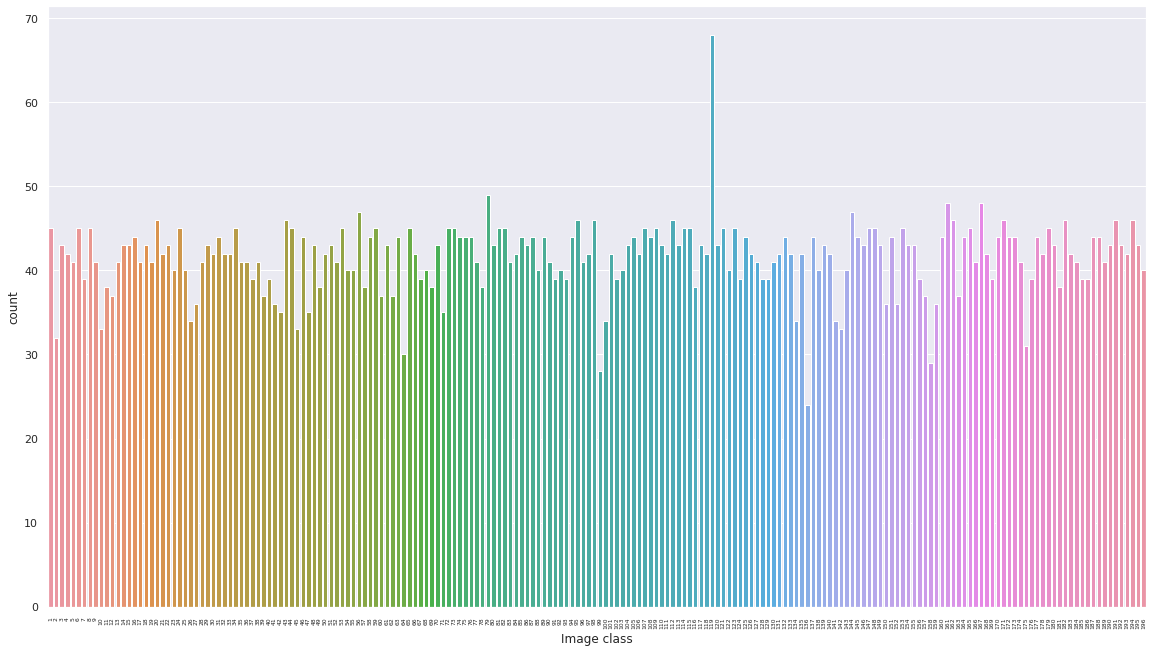

In [10]:
sns.set(rc = {'figure.figsize': (16, 9), 'xtick.labelsize': 6})
plt.xticks(rotation = 90)
plt.tight_layout()
sns.countplot(x = train_annotation["Image class"]);
plt.rcParams.update(plt.rcParamsDefault)

In [11]:
train_annotation[train_annotation["Image class"] != 119].groupby("Image class").size().mean()

41.41538461538462

In [12]:
car_names_make.loc[119]

Car Name and Make    GMC Yukon Hybrid SUV 2012
Name: 119, dtype: object

In [13]:
len(train_annotation[train_annotation["Image class"] == 119])

68

***On average each class has 41.4 images each with an exception of class number 119 (GMC Yukon Hybrid SUV 2012), which has 68 images.***

**Function to get image path by index and whether it is from the train set or the test set**

In [14]:
def get_path(index, data_type = 0):
    if data_type == 0: # Train Images
        data_dir = train_dir
        data_annotation = train_annotation 
    elif data_type == 1: # Test Images
        data_dir = test_dir
        data_annotation = test_annotation
    elif data_type == 2: # Augmentation Train Images
        data_dir = aug_dir
        data_annotation = aug_annotation
        img_file = os.path.join(data_dir, data_annotation["Image Name"][index])
        return img_file
    else:
        print("Please choose 0 for train set, 1 for test set, or 2 for augmented train set only only.")
        return
    
    file_path = os.path.join(data_dir, car_names_make.loc[int(data_annotation["Image class"][index])-1][0])
    img_file = os.path.join(file_path, data_annotation["Image Name"][index])
    return img_file

**Function to display the image with the respective bounding box given an index and whether it is from the train or the test set**

In [15]:
def show_car(index, data_type = 0):
    
    if data_type == 0:
        img_path = get_path(index, data_type)
        data_annotation = train_annotation
    elif data_type == 1:
        img_path = get_path(index, data_type)
        data_annotation = test_annotation
    elif data_type == 2:
        img_path = get_path(index, data_type)
        data_annotation = aug_annotation
    else:
        print("Please choose 0 for train set, 1 for test set, or 2 for augmented train set only only.")
        return
    
    img = imread(img_path)
    
    x = data_annotation.loc[index]["BB x1"]
    y = data_annotation.loc[index]["BB y1"]
    w = data_annotation.loc[index]["BB x2"] - x
    h = data_annotation.loc[index]["BB y2"] - y
    
    fig, ax = plt.subplots(1)
    plt.imshow(img)
    rect = patches.Rectangle((x, y), w, h, linewidth = 2, edgecolor = 'r', facecolor = 'none', label = data_annotation.loc[index]["Image Name"])
    ax.add_patch(rect)
    
    plt.show()
    print(data_annotation.loc[index]["Image class"])
    print(img.shape)
    print("x: ", x, "y: ", y, "w: ", w, "h: ", h)

**Let's see a random car**

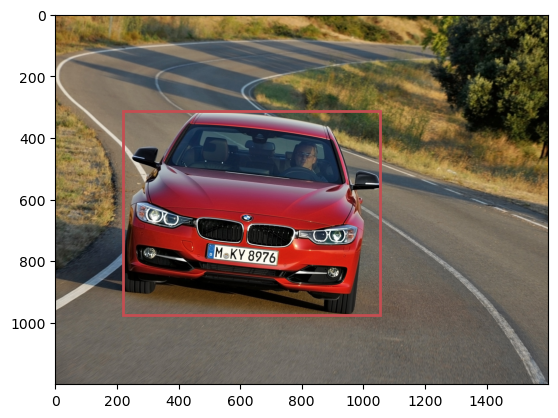

29
(1200, 1600, 3)
x:  220 y:  313 w:  834 h:  663


In [16]:
show_car(69)

**Fixing some typos in the Car Name and Make DataFrame**

***Ram C-V Cargo Van Minivan 2012 is misnamed in Car_Name_Make and hence is crashing when we look up the directory, we must fix this***

In [17]:
car_names_make[car_names_make["Car Name and Make"].str.match("Ram")]

,Car Name and Make
173,Ram C/V Cargo Van Minivan 2012


***Index procured 173, editing manually to Ram C-V Cargo Van Minivan 2012***

In [18]:
car_names_make.loc[173][0] = "Ram C-V Cargo Van Minivan 2012"

***Fixed it***

**Validation of the ground truth**

In [19]:
def compare_BB_size(index, data_type = 0, threshold_max = 0.99, threshold_min = 0.05):
    if data_type == 0:
        img_path = get_path(index, data_type)
        data_annotation = train_annotation
    elif data_type == 1:
        img_path = get_path(index, data_type)
        data_annotation = test_annotation
    elif data_type == 2:
        img_path = get_path(index, data_type)
        data_annotation = aug_annotation
    else:
        print("Please choose 0 for train set, 1 for test set, or 2 for augmented train set only only.")
        return
    
    img = imread(img_path)
    
    img_area = img.shape[0] * img.shape[1]
    
    x = data_annotation.loc[index]["BB x1"]
    y = data_annotation.loc[index]["BB y1"]
    w = data_annotation.loc[index]["BB x2"] - x
    h = data_annotation.loc[index]["BB y2"] - y
    
    BB_area = w * h
    
#     if(BB_area / img_area > threshold_max):
#         print("%d index car's bounding box is way too big, please verify manually" %i)
    if(BB_area / img_area < threshold_min):
        print("%d index car's bounding box is way too small, please verify manually" %i)
    if(x < 0 or y < 0 or h > img.shape[0] or w > img.shape[1]):
        print("%d index car's bounding box is at the edge of the image, please verify manually" %i)
        print("x: ", x, "y: ", y, "w: ", w, "W: ", img.shape[1], "h: ", h, "H: ", img.shape[0])
    

In [20]:
for i in range(len(train_annotation)):
    compare_BB_size(i, 0)

5596 index car's bounding box is way too small, please verify manually
7388 index car's bounding box is at the edge of the image, please verify manually
x:  56 y:  89 w:  661 W:  576 h:  430 H:  768


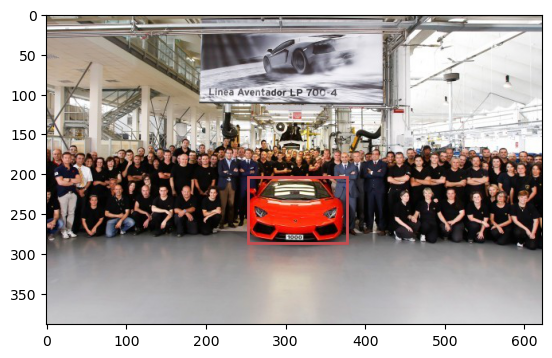

151
(389, 623, 3)
x:  253 y:  204 w:  124 h:  82


In [21]:
show_car(5596)

***Small, but seems to be okay still, recognisable***

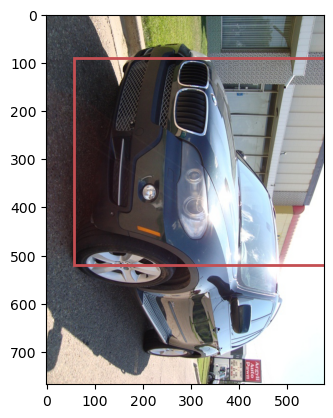

32
(768, 576, 3)
x:  56 y:  89 w:  661 h:  430


In [22]:
show_car(7388)

***The image seems to be rotated 90 degrees clockwise with respect to the bounding box, let's fix the bounding box and see if that helps***

In [23]:
train_annotation.loc[7388]

Image Name     07389.jpg
BB x1                 56
BB y1                 89
BB x2                717
BB y2                519
Image class           32
Name: 7388, dtype: object

In [24]:
# to rotate bounding box clockwise, make x1' = W - y2, x2' = W - y1, y1' = x1, y2' = x2
img = imread(get_path(7388))
W = img.shape[1]
x1_new = W - train_annotation["BB y2"][7388]
x2_new = W - train_annotation["BB y1"][7388]
y1_new = train_annotation["BB x1"][7388]
y2_new = train_annotation["BB x2"][7388]
train_annotation["BB x1"][7388] = x1_new
train_annotation["BB y1"][7388] = y1_new
train_annotation["BB x2"][7388] = x2_new
train_annotation["BB y2"][7388] = y2_new

C:\Users\alway\AppData\Local\Temp/ipykernel_16352/1350870944.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_annotation["BB x1"][7388] = x1_new
C:\Users\alway\AppData\Local\Temp/ipykernel_16352/1350870944.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_annotation["BB y1"][7388] = y1_new
C:\Users\alway\AppData\Local\Temp/ipykernel_16352/1350870944.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_annotation[

In [25]:
train_annotation.loc[7388]

Image Name     07389.jpg
BB x1                 57
BB y1                 56
BB x2                487
BB y2                717
Image class           32
Name: 7388, dtype: object

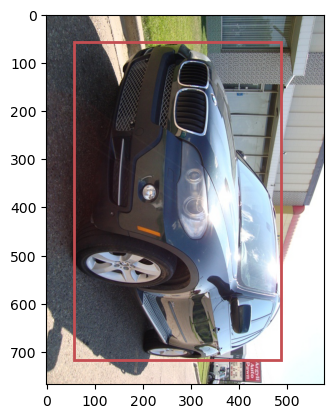

32
(768, 576, 3)
x:  57 y:  56 w:  430 h:  661


In [26]:
show_car(7388)

**Data augmentation**

In [27]:
aug_seq = iaa.Sequential([iaa.Fliplr(0.5),
                          iaa.Flipud(0.2),
                          iaa.Sometimes(0.5, iaa.Crop(percent = (0, 0.1))),
#                           iaa.Sometimes(0.5, iaa.GaussianBlur(sigma = (0, 0.5))),
                          iaa.Affine(
                              scale = {"x": (0.8, 1.0), "y": (0.8, 1.0)}, # limit to 100 
#                               translate_percent = {"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # remove maybe?
#                               rotate = (-25, 25),
#                               shear = (-8, 8)
                          ),
                         iaa.SomeOf((0, 5),
                                   [
                                       iaa.Sometimes(0.5, iaa.Superpixels(p_replace = (0, 1.0),
                                                                n_segments = (20, 200))),
                                       iaa.OneOf([
                                           iaa.GaussianBlur((0, 0.3)),
                                           iaa.AverageBlur(k = (2, 7)),
                                           iaa.MedianBlur(k = (3, 11)),
                                       ]),
                                       iaa.Sharpen(alpha = (0, 1.0), lightness = (0.75, 1.5)),
                                       iaa.Emboss(alpha = (0, 1.0), strength = (0, 2.0)),
                                       iaa.Sometimes(0.5, iaa.OneOf([
                                           iaa.EdgeDetect(alpha = (0, 0.7)),
                                           iaa.DirectedEdgeDetect(alpha = (0, 0.7), direction = (0.0, 1.0)),
                                       ])),
                                       iaa.AdditiveGaussianNoise(loc = 0, scale = (0.0, 0.05 * 255), per_channel = 0.5),
                                       iaa.OneOf([
                                           iaa.Dropout((0.01, 0.1), per_channel = 0.5),
                                           iaa.CoarseDropout((0.03, 0.15), size_percent = (0.02, 0.05), per_channel = 0.2),
                                       ]),
                                       iaa.Invert(0.05, per_channel = True),
                                       iaa.Add((-10, 10), per_channel = 0.5),
                                       iaa.Multiply((0.8, 1.0), per_channel = 0.2),
                                       iaa.LinearContrast((0.75, 1.5)),
#                                        iaa.Grayscale(alpha = (0.0, 0.7)),
                                       iaa.Sometimes(0.5, iaa.ElasticTransformation(alpha = (0.5, 2.5), sigma = 0.25)),
                                       iaa.Sometimes(0.5, iaa.PiecewiseAffine(scale = (0.01, 0.05)))                                       
                                   ],
                                   random_order = True)], random_order = True)

In [28]:
aug_annotation = pd.DataFrame(columns = ["Image Name", "BB x1", "BB y1", "BB x2", "BB y2", "Image class"])

In [29]:
if len(os.listdir(aug_dir)) < 45000:
    for i in range(len(train_annotation)):
        for j in range(5):
            image = imread(get_path(i))
            imageH = image.shape[0]
            imageW = image.shape[1]
            image = ia.imresize_single_image(image, (224, 224))
            bbs = BoundingBox(x1 = train_annotation.loc[i]["BB x1"] * 224 / imageW, 
                              x2 = train_annotation.loc[i]["BB x2"] * 224 / imageW, 
                              y1 = train_annotation.loc[i]["BB y1"]  * 224 / imageH, 
                              y2 = train_annotation.loc[i]["BB y2"]  * 224 / imageH, 
                              label = car_names_make.loc[int(train_annotation["Image class"][i])-1][0])
            image_aug, bbs_aug = aug_seq(image = image, bounding_boxes = bbs)
            bbs_aug = bbs_aug.clip_out_of_image(image)

            imageio.imwrite(os.path.join(aug_dir, "aug" + str(j) + "_" + train_annotation["Image Name"][i]), image_aug)
            df2 = {"Image Name": "aug" + str(j) + "_" + train_annotation["Image Name"][i], 
                   "BB x1": bbs_aug[0][0], 
                   "BB y1": bbs_aug[0][1], 
                   "BB x2": bbs_aug[1][0], 
                   "BB y2": bbs_aug[1][1], 
                   "Image class": train_annotation["Image class"][i]}
            aug_annotation = aug_annotation.append(df2, ignore_index = True)

            if j == 0:
                imageio.imwrite(os.path.join(aug_dir, "%s" %(train_annotation["Image Name"][i],)), image)
                df2 = {"Image Name": train_annotation["Image Name"][i], 
                       "BB x1": bbs[0][0], 
                       "BB y1": bbs[0][1], 
                       "BB x2": bbs[1][0], 
                       "BB y2": bbs[1][1], 
                       "Image class": train_annotation["Image class"][i]}
                aug_annotation = aug_annotation.append(df2, ignore_index = True)
else:
    aug_annotation = pd.read_csv(os.path.join(data_dir, "Annotations", "Train Augmented Annotations.csv"))

In [30]:
aug_annotation.head()

,Image Name,BB x1,BB y1,BB x2,BB y2,Image class
0,aug0_00001.jpg,25.589615,22.039536,195.84056,155.18102,14
1,00001.jpg,14.560000,64.960000,212.42667,210.00000,14
2,aug1_00001.jpg,21.816452,65.301750,199.50151,209.28802,14
3,aug2_00001.jpg,22.040058,69.584230,204.71733,200.36618,14
4,aug3_00001.jpg,32.954150,68.996370,193.46870,201.59090,14


In [31]:
aug_annotation.to_csv(os.path.join(data_dir, "Annotations", "Train Augmented Annotations.csv"), index = False)

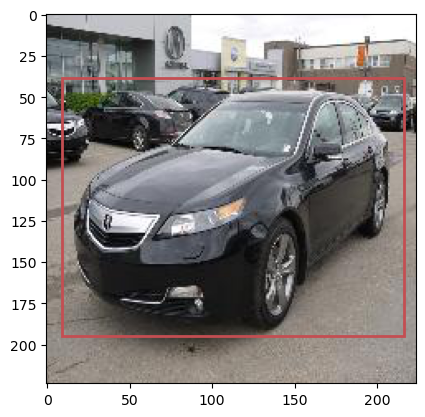

3
(224, 224, 3)
x:  8.96 y:  38.494816 w:  207.07555 h:  156.30222400000002


In [32]:
show_car(7, 2)

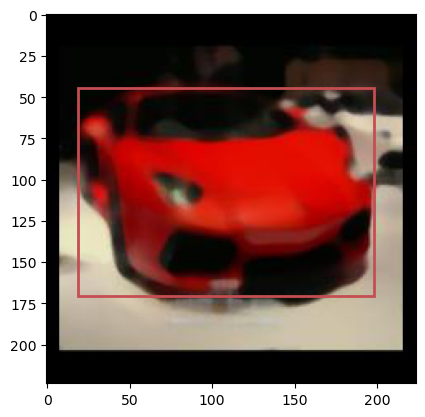

151
(224, 224, 3)
x:  18.476418 y:  44.53529 w:  179.638782 h:  125.89580000000001


In [38]:
show_car(5042, 2)

**Split the data into train and validation and the pickle it**

In [71]:
read_images = []
for img in aug_annotation["Image Name"]:
    read_images.append(cv2.imread(os.path.join(aug_dir, img)))
images = np.array(read_images)

In [84]:
X_aug = aug_annotation.iloc[:,:-1]
y_aug = aug_annotation["Image class"]

In [136]:
X_train, X_val, y_train, y_val = train_test_split(X_aug, y_aug, test_size = 0.3)

In [143]:
X_train_imgs = []
for i, row in X_train.iterrows():
    X_train_imgs.append(images[i])

In [170]:
X_val_imgs = []
for i, row in X_val.iterrows():
    X_val_imgs.append(images[i])

In [149]:
train_dict = {"X_train": X_train_imgs, "y_train": y_train}
with open('train_dict.pickle', 'wb') as file:
    pickle.dump(train_dict, file)
val_dict = {"X_val": X_val_imgs, "y_val": y_val}
with open('val_dict.pickle', 'wb') as file:
    pickle.dump(val_dict, file)

In [165]:
print(len(X_train_imgs), len(X_train_imgs[0]),len(X_train_imgs[0][0]), len(X_train_imgs[0][0][0]))

34204 224 224 3


### Conjoined Network (Since calling them Siamese is offensive)

**Generating one-hot encoding for the classes**

In [53]:
def generate_one_hot_classes(classes):
    encoder = LabelBinarizer()
    transformed_labels = encoder.fit_transform(classes)
    return transformed_labels

In [54]:
labels = generate_one_hot_classes(list(car_names_make["Car Name and Make"]))

In [56]:
print(labels)
len(labels)

[[1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


196

**Defining the model**

In [60]:
K.set_image_data_format('channels_last')

def get_conjoined_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        but with LeakyReLU
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    model = Sequential()
    model.add(Conv2D(64, (10, 10), activation = LeakyReLU(), input_shape = input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7, 7), activation = LeakyReLU()))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4, 4), activation = LeakyReLU()))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4, 4), activation = LeakyReLU()))
    model.add(Flatten())
    model.add(Dense(4096, activation = 'sigmoid'))
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1, activation = 'sigmoid')(L1_distance)
    conjoined_net = Model(inputs = [left_input, right_input], outputs = prediction)
    
    return conjoined_net

In [61]:
conjoined_net = get_conjoined_model((224, 224, 3))
conjoined_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         420642112   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[0][0]           

In [62]:
optimiser = Adam(lr = 0.00006)
conjoined_net.compile(loss = 'binary_crossentropy', optimizer = optimiser)

In [ ]:
class Conjoined_Loader:
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + '_dict.pickle')
            print("Loading data from {}".format(file_path))
            with open(file_path, 'rb') as f:
                (X, c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c
                
    def get_batch(self, batch_size, s = 'train'):
        """Create batch of n pairs, half same class, half different class"""
        X = self.data[s]
        n_examples = len(X)
        w = len(X[0])
        h = len(X[0][0])
        n_channels = len(X[0][0][0])
        
        #Randomly sample several classes to use in the batch
        categories = np.random.choice(n_classes)